## [ISIC Challenge (2016-2020)](https://challenge.isic-archive.com/)
---

### [Data 2018](https://challenge.isic-archive.com/data/)

The input data are dermoscopic lesion images in JPEG format.

All lesion images are named using the scheme `ISIC_<image_id>.jpg`, where `<image_id>` is a 7-digit unique identifier. EXIF tags in the images have been removed; any remaining EXIF tags should not be relied upon to provide accurate metadata.

The lesion images were acquired with a variety of dermatoscope types, from all anatomic sites (excluding mucosa and nails), from a historical sample of patients presented for skin cancer screening, from several different institutions. Every lesion image contains exactly one primary lesion; other fiducial markers, smaller secondary lesions, or other pigmented regions may be neglected.

The distribution of disease states represent a modified "real world" setting whereby there are more benign lesions than malignant lesions, but an over-representation of malignancies.

In [1]:
import os
import glob
import numpy as np
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.io import read_image
from torchvision.io.image import ImageReadMode

In [2]:
class ISIC2018Dataset(Dataset):
    def __init__(self, data_dir=None, one_hot=True, img_transform=None, msk_transform=None):
        # pre-set variables
        self.data_prefix = "ISIC_"
        self.target_postfix = "_segmentation"
        self.target_fex = "png"
        self.input_fex = "jpg"
        self.data_dir = data_dir if data_dir else "/path/to/datasets/ISIC2018"
        self.imgs_dir = os.path.join(self.data_dir, "ISIC2018_Task1-2_Training_Input")
        self.msks_dir = os.path.join(self.data_dir, "ISIC2018_Task1_Training_GroundTruth")
        
        # input parameters
        self.img_dirs = glob.glob(f"{self.imgs_dir}/*.{self.input_fex}")
        self.data_ids = [d.split(self.data_prefix)[1].split(f".{self.input_fex}")[0] for d in self.img_dirs]
        self.one_hot = one_hot
        self.img_transform = img_transform
        self.msk_transform = msk_transform
        
    def get_img_by_id(self, id):
        img_dir = os.path.join(self.imgs_dir, f"{self.data_prefix}{id}.{self.input_fex}")
        img = read_image(img_dir, ImageReadMode.RGB)
        return img
    
    def get_msk_by_id(self, id):
        msk_dir = os.path.join(self.msks_dir, f"{self.data_prefix}{id}{self.target_postfix}.{self.target_fex}")
        msk = read_image(msk_dir, ImageReadMode.GRAY)
        return msk

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        img = self.get_img_by_id(data_id)
        msk = self.get_msk_by_id(data_id)

        if self.img_transform:
            img = self.img_transform(img)
            img = (img - img.min())/(img.max() - img.min())
        if self.msk_transform:
            msk = self.msk_transform(msk)
            msk = (msk - msk.min())/(msk.max() - msk.min())
        
        if self.one_hot:
            msk = F.one_hot(torch.squeeze(msk).to(torch.int64))
            msk = torch.moveaxis(msk, -1, 0).to(torch.float)

        sample = {'image': img, 'mask': msk, 'id': data_id}
        return sample

In [3]:
class ISIC2018DatasetFast(Dataset):
    def __init__(self, mode, data_dir=None, one_hot=True, img_transform=None, msk_transform=None):
        # pre-set variables
        self.data_dir = data_dir if data_dir else "/path/to/datasets/ISIC2018/np"
        
        # input parameters
        self.one_hot = one_hot
        
        X = np.load(f"{self.data_dir}/X_tr_224x224.npy")
        Y = np.load(f"{self.data_dir}/Y_tr_224x224.npy")
        
        X = torch.tensor(X)
        Y = torch.tensor(Y)
        
        if mode == "tr":
            self.imgs = X[0:1815]
            self.msks = Y[0:1815]
        elif mode == "vl":
            self.imgs = X[1815:1815+259]
            self.msks = Y[1815:1815+259]
        elif mode == "te":
            self.imgs = X[1815+259:2594]
            self.msks = Y[1815+259:2594]
        else:
            raise ValueError()

    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        data_id = idx
        img = self.imgs[idx]
        msk = self.msks[idx]
        
        if self.one_hot:
            msk = F.one_hot(torch.squeeze(msk).to(torch.int64))
            msk = torch.moveaxis(msk, -1, 0).to(torch.float)

        sample = {'image': img, 'mask': msk, 'id': data_id}
        return sample

In [4]:
class ISIC2018ValidationDataset(Dataset):
    def __init__(self, data_dir=None, img_transform=None, msk_transform=None):
        # pre-set variables
        self.data_prefix = "ISIC_"
        self.target_postfix = "_segmentation"
        self.target_fex = "png"
        self.input_fex = "jpg"
        self.data_dir = data_dir if data_dir else "/path/to/datasets/ISIC2018"
        self.imgs_dir = os.path.join(self.data_dir, "ISIC2018_Task1-2_Validation_Input")
        self.msks_dir = os.path.join(self.data_dir, "ISIC2018_Task1_Validation_GroundTruth")
        
        # input parameters
        self.img_dirs = glob.glob(f"{self.imgs_dir}/*.{self.input_fex}")
        self.data_ids = [d.split(self.data_prefix)[1].split(f".{self.input_fex}")[0] for d in self.img_dirs]
        self.img_transform = img_transform
        self.msk_transform = msk_transform
        
    def get_img_by_id(self, id):
        img_dir = os.path.join(self.imgs_dir, f"{self.data_prefix}{id}.{self.input_fex}")
        img = read_image(img_dir, ImageReadMode.RGB)
        return img
    
    def get_msk_by_id(self, id):
        msk_dir = os.path.join(self.msks_dir, f"{self.data_prefix}{id}{self.target_postfix}.{self.target_fex}")
        msk = read_image(msk_dir, ImageReadMode.GRAY)
        return msk

    def __len__(self):
        return len(self.data_ids)

    def __getitem__(self, idx):
        data_id = self.data_ids[idx]
        img = self.get_img_by_id(data_id)
        msk = self.get_msk_by_id(data_id)
        
        print(f"msk shape: {msk.shape}")
        print(f"img shape: {img.shape}")
        

        if self.img_transform:
            img = self.img_transform(img)
            img = (img - img.min())/(img.max() - img.min())
        if self.msk_transform:
            msk = self.msk_transform(msk)
            msk = (msk - msk.min())/(msk.max() - msk.min())
        
        sample = {'image': img, 'mask': msk, 'id': data_id}
        return sample

Training


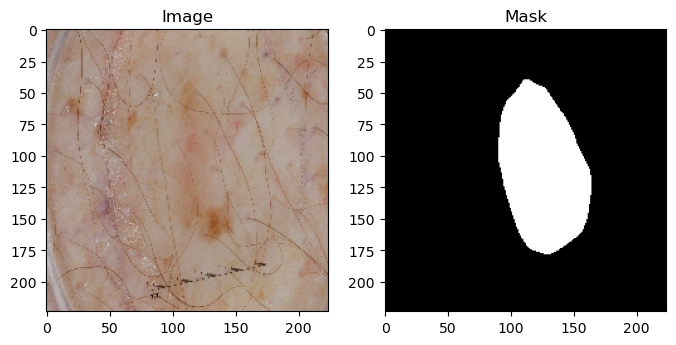

Validation


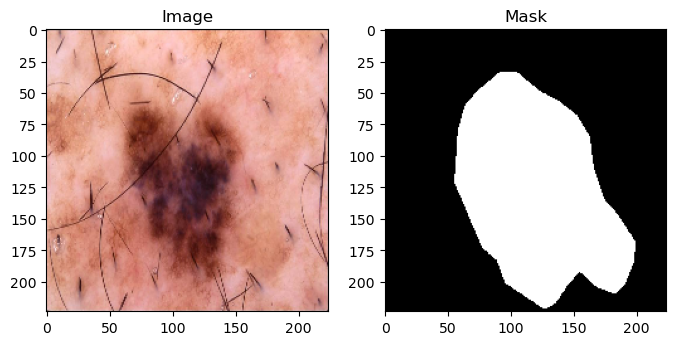

Test


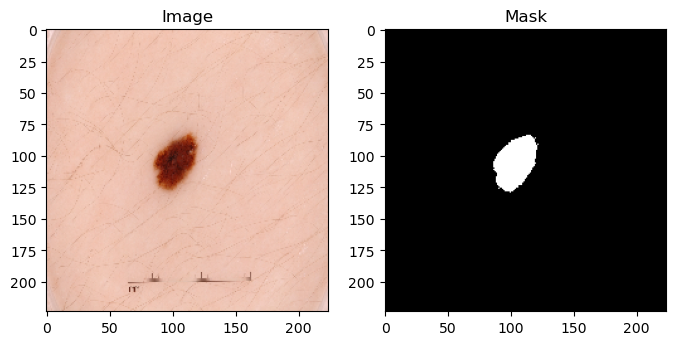

In [5]:
tr_dataset = ISIC2018DatasetFast(mode='tr')
vl_dataset = ISIC2018DatasetFast(mode='vl')
te_dataset = ISIC2018DatasetFast(mode='te')

# ------------------- params --------------------
INPUT_SIZE = 224

TR_BATCH_SIZE = 8
TR_DL_SHUFFLE = True
TR_DL_WORKER = 1

VL_BATCH_SIZE = 12
VL_DL_SHUFFLE = False
VL_DL_WORKER = 1

TE_BATCH_SIZE = 12
TE_DL_SHUFFLE = False
TE_DL_WORKER = 1
# <<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<<


# prepare train dataloader
tr_loader = DataLoader(
    tr_dataset, 
    batch_size=TR_BATCH_SIZE, 
    shuffle=TR_DL_SHUFFLE, 
    num_workers=TR_DL_WORKER,
    pin_memory=True
)

# prepare validation dataloader
vl_loader = DataLoader(
    vl_dataset, 
    batch_size=VL_BATCH_SIZE, 
    shuffle=VL_DL_SHUFFLE, 
    num_workers=VL_DL_WORKER,
    pin_memory=True
)

# prepare test dataloader
te_loader = DataLoader(
    te_dataset, 
    batch_size=TE_BATCH_SIZE, 
    shuffle=TE_DL_SHUFFLE, 
    num_workers=TE_DL_WORKER,
    pin_memory=True
)

# -------------- test -----------------
import sys
sys.path.append('..')
from utils import show_sbs

# test and visualize the input data
for sample in tr_loader:
    img = sample['image']
    msk = sample['mask']
    print("Training")
    show_sbs(img[0], msk[0,1])
    break
    
for sample in vl_loader:
    img = sample['image']
    msk = sample['mask']
    print("Validation")
    show_sbs(img[0], msk[0,1])
    break
    
for sample in te_loader:
    img = sample['image']
    msk = sample['mask']
    print("Test")
    show_sbs(img[0], msk[0,1])
    break

In [6]:
!ls /path/to/datasets/ISIC2018/np

X_tr_224x224.npy  Y_tr_224x224.npy
